# Covid Cases Dataset
_____

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

import plotly.figure_factory as ft 

In [159]:
df_cases = pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
df_cases = df_cases[['submission_date','state','tot_cases','new_case','tot_death','new_death']]
df_cases.head()

,submission_date,state,tot_cases,new_case,tot_death,new_death
0,01/25/2020,OR,0,0,0,0
1,09/17/2021,MD,"516,784","1,525","10,282",11
2,10/12/2021,VT,"33,388",112,333,4
3,02/01/2021,DC,"37,008",136,916,3
4,12/19/2021,NC,"1,586,243","3,410","19,480",19


In [160]:
df_cases['submission_date'] = pd.to_datetime(df_cases['submission_date'])

In [161]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59640 entries, 0 to 59639
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   submission_date  59640 non-null  datetime64[ns]
 1   state            59640 non-null  object        
 2   tot_cases        59640 non-null  object        
 3   new_case         59640 non-null  object        
 4   tot_death        59640 non-null  object        
 5   new_death        59640 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 2.7+ MB


In [162]:
df_cases.set_index('submission_date', inplace=True)
df_cases.sort_index(inplace=True)

In [163]:
df_cases.columns

Index(['state', 'tot_cases', 'new_case', 'tot_death', 'new_death'], dtype='object')

In [164]:
df_cases['tot_cases'].value_counts()

0            4117
4             578
1             280
3             195
2             161
             ... 
401,591         1
526,423         1
815,593         1
621,542         1
7,135,916       1
Name: tot_cases, Length: 42844, dtype: int64

In [165]:
df_cases['new_case'].value_counts()

0         14040
1           346
2           277
3           185
4           167
          ...  
13,181        1
10,421        1
21,940        1
16,373        1
5,470         1
Name: new_case, Length: 8121, dtype: int64

In [166]:
col =['tot_cases', 'new_case', 'tot_death', 'new_death']
for c in col:
    df_cases[c] = df_cases[c].map( lambda x: x.replace(',','')).astype(int)
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [167]:
df_cases[df_cases['tot_cases']==0].count()

state        4117
tot_cases    4117
new_case     4117
tot_death    4117
new_death    4117
dtype: int64

In [168]:
df_cases.head(70)

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2020-01-23,PR,0,0,0,0
2020-01-23,LA,0,0,0,0
2020-01-23,OR,0,0,0,0


In [169]:
#df_cases.drop(df_cases[df_cases['tot_cases']==0].index, inplace=True)

In [170]:
df_cases.shape

(59640, 5)

In [171]:
df_cases.head(70)

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2020-01-23,PR,0,0,0,0
2020-01-23,LA,0,0,0,0
2020-01-23,OR,0,0,0,0


##  EDA - Covid Cases in US 
_____

In [172]:
# Creating a copy of dataset to perform EDA
df_deaths = df_cases.copy()

df = df_cases.copy()


In [173]:
# I will perform EDA in US cases so I need to sum cases from all states.
# to do this I will sum the cases for the same dates using group by.
# I can't use tot_cases because this column is acumulative so I will sum the new cases.
df = df.groupby(by=df.index).sum()
df.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


In [174]:
df.drop(columns=['tot_cases','tot_death','new_death'], inplace=True)

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2020-01-22 to 2022-10-11
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   new_case  994 non-null    int64
dtypes: int64(1)
memory usage: 15.5 KB


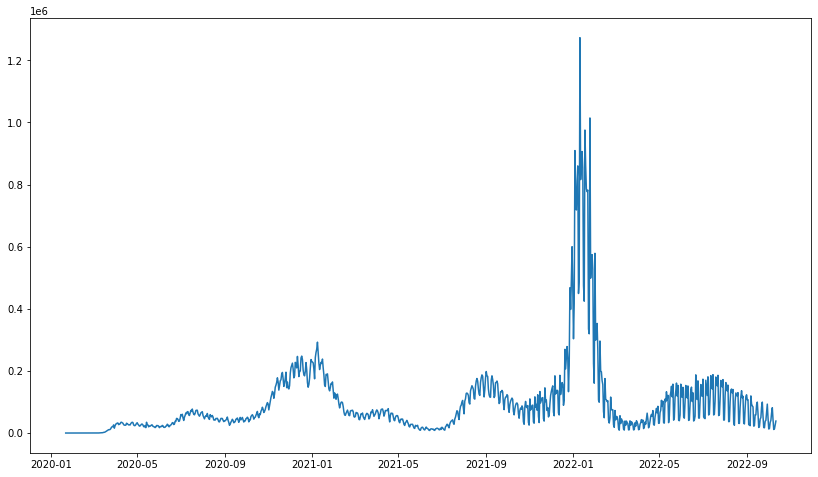

In [176]:
plt.figure(figsize=(14,8))
plt.plot(df['new_case']);

In [177]:
df = df.resample('W').mean()
df_cases_diff = df.copy()
df.head()

,new_case
submission_date,
2020-01-26,1.600000
2020-02-02,0.714286
2020-02-09,1.000000
2020-02-16,0.571429
2020-02-23,3.428571


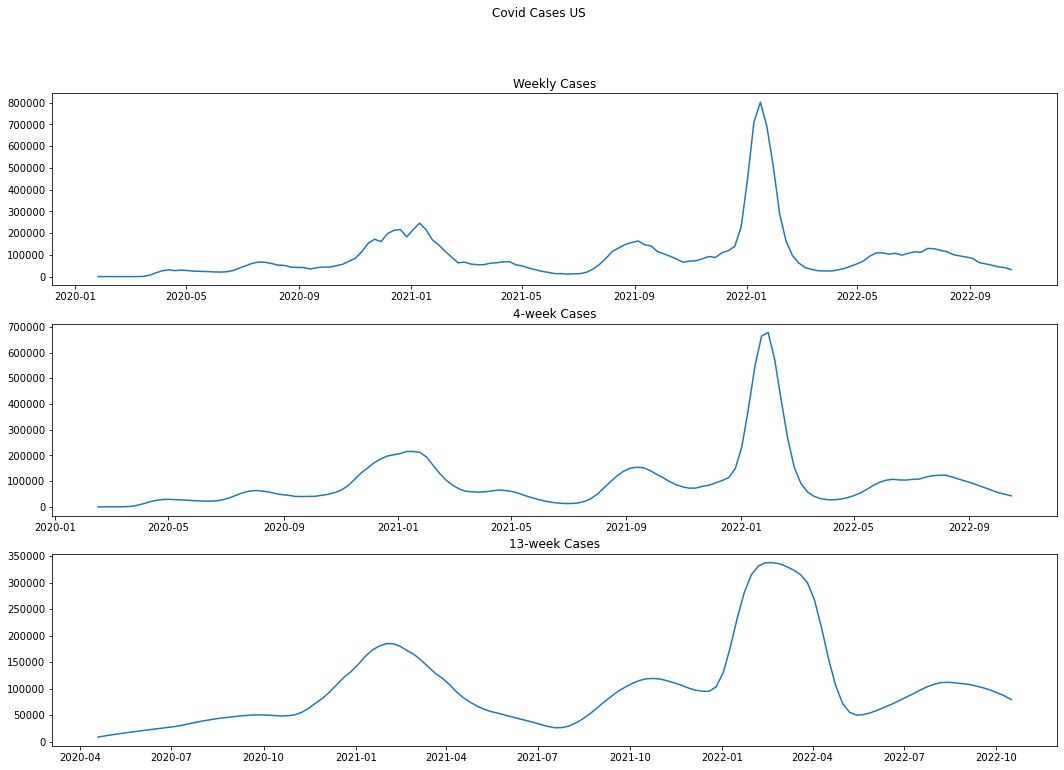

In [178]:
df['moving_average_1'] = df['new_case'].rolling(window=1).mean()
df['moving_average_4'] = df['new_case'].rolling(window=4).mean()
df['moving_average_13'] = df['new_case'].rolling(window=13).mean()

fig, axes = plt.subplots(nrows=3, figsize=(18,12))

axes[0].plot(df['moving_average_1'])
axes[1].plot(df['moving_average_4'])
axes[2].plot(df['moving_average_13'])


fig.suptitle('Covid Cases US')
axes[0].title.set_text('Weekly Cases')
axes[1].title.set_text('4-week Cases')
axes[2].title.set_text('13-week Cases')



In [179]:
df.dropna(inplace=True)
df.head()

,new_case,moving_average_1,moving_average_4,moving_average_13
submission_date,,,,
2020-04-19,27436.857143,27436.857143,25772.964286,8494.298901
2020-04-26,30087.571429,30087.571429,28939.857143,10808.604396
2020-05-03,27584.571429,27584.571429,29096.714286,12930.439560
2020-05-10,24957.142857,24957.142857,27516.535714,14850.142857
2020-05-17,24088.142857,24088.142857,26679.357143,16703.032967


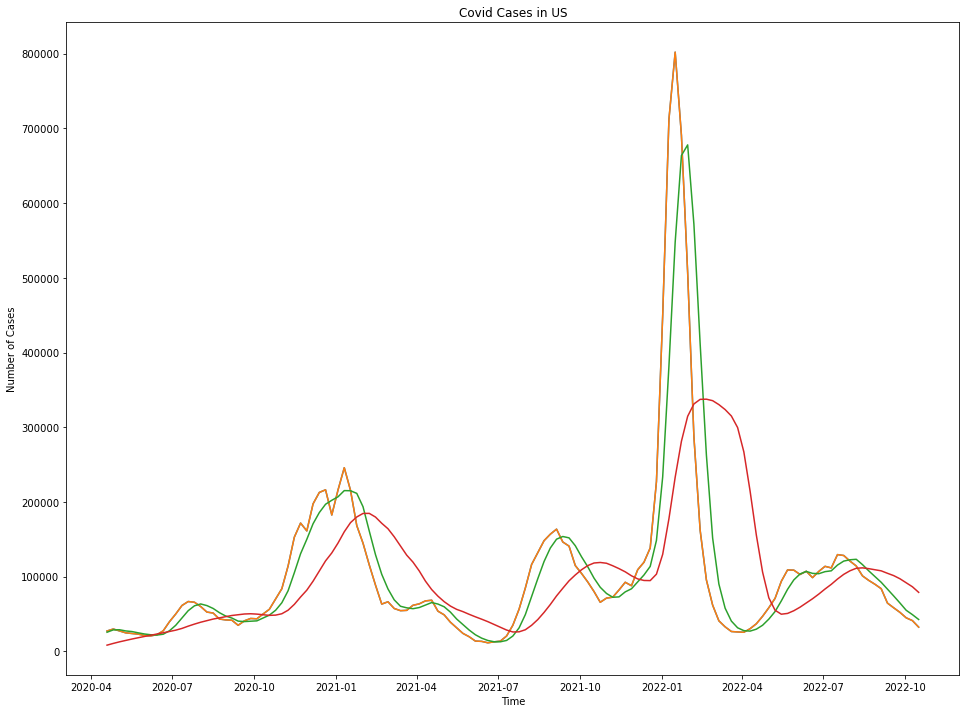

In [180]:
plt.figure(figsize=(16,12))
plt.plot(df)
plt.title('Covid Cases in US')
plt.xlabel('Time')
plt.ylabel('Number of Cases');

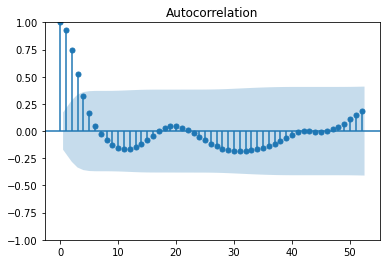

In [181]:
# Generate the ACF plot on Weekly Sales data up to 52 time periods.
plot_acf(df['new_case'], lags = 52);

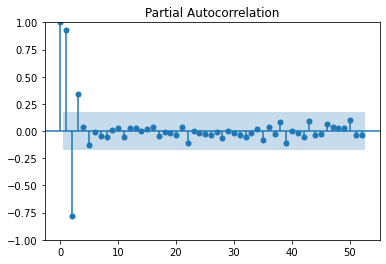

In [182]:
plot_pacf(df['new_case'], lags = 52, method='ywm' );

### Evaluating Stationary
---

In [183]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -3.264758
p-value           0.016529
dtype: float64

` Because our p (0.016529) is bigger than alpha (0.01) we can not  accept that our series "new_cases" is stationary.`

In [184]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [185]:
y_train.tail()

submission_date
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
2022-07-10    111881.000000
Freq: W-SUN, Name: new_case, dtype: float64

In [186]:
y_test.head()

submission_date
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
2022-08-14    101213.571429
Freq: W-SUN, Name: new_case, dtype: float64

In [187]:
# Instantiate best model.
#arima_5201 = ARIMA(endog = y_train, order = (52, 0, 1))
arima_5201 = ARIMA(endog = y_train, order = (3, 0, 1))

# Fit ARIMA model.
model_5201 = arima_5201.fit()

In [188]:
# Generate predictions based on test set.
preds_5201 = model_5201.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_5201 = model_5201.predict(start = y_train.index[0], end = y_train.index[-1])

In [189]:
from sklearn import metrics
metrics.mean_squared_error(y_test, preds_5201)

1670139099.9838376

Text(0.5, 1.0, 'Weekly Sales for Store 1 with ARIMA(3, 0, 1) Predictions')

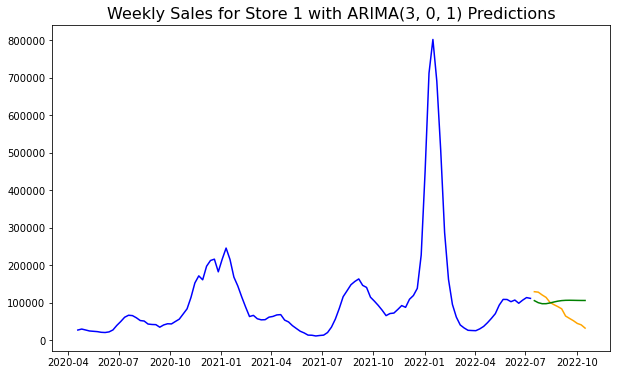

In [190]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_5201, color = 'green')

plt.title(label = 'Weekly Sales for Store 1 with ARIMA(3, 0, 1) Predictions', fontsize=16)

### SARIMA
----

In [191]:
# Fit a SARIMA(3, 0, 1) x (1, 1, 1, 22) model.
sarima = SARIMAX(endog = y_train,
                  order = (3, 0, 1),                # (p, d, q)
                  seasonal_order=(1,1,1,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01876D+01    |proj g|=  1.53410D+00


 This problem is unconstrained.



At iterate    5    f=  9.61380D+00    |proj g|=  4.07625D-02

At iterate   10    f=  9.60119D+00    |proj g|=  5.82532D-03

At iterate   15    f=  9.59915D+00    |proj g|=  1.00264D-03

At iterate   20    f=  9.59915D+00    |proj g|=  1.96093D-04

At iterate   25    f=  9.59912D+00    |proj g|=  1.21219D-03

At iterate   30    f=  9.59910D+00    |proj g|=  3.42874D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     36      1     0     0   9.947D-06   9.599D+00
  F =   9.5991029623177706     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [192]:
# Generate predictions based on test set.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

In [193]:
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

436284355.8369504

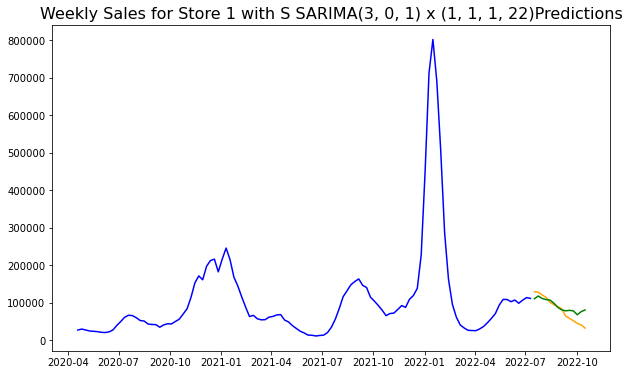

In [194]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

    #order = (3, 0, 1),                # (p, d, q)
     # seasonal_order=(1,1,1,22))     

plt.title(label = 'Weekly Sales for Store 1 with S SARIMA(3, 0, 1) x (1, 1, 1, 22)Predictions', fontsize=16)
plt.show();

In [195]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0


In [196]:
df_cases_diff.head()

,new_case
submission_date,
2020-01-26,1.600000
2020-02-02,0.714286
2020-02-09,1.000000
2020-02-16,0.571429
2020-02-23,3.428571


In [197]:
df_cases_diff['diff_1'] = df_cases_diff['new_case'].diff()
df_cases_diff['diff_2'] = df_cases_diff['new_case'].diff().diff()
df_cases_diff.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-01-26,1.600000,NaN,NaN
2020-02-02,0.714286,-0.885714,NaN
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714


In [198]:
df_cases_diff.dropna(inplace=True)
df_cases_diff.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714
2020-03-01,7.428571,4.000000,1.142857
2020-03-08,103.142857,95.714286,91.714286


In [199]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df_cases_diff['new_case']))

Test Statistic   -3.320787
p-value           0.013974
dtype: float64

In [200]:
# Create train-test split.
y_train, y_test = train_test_split(df_cases_diff['new_case'], test_size = 0.1,shuffle = False)

In [201]:
y_train.tail()

submission_date
2022-06-05    103067.428571
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
Freq: W-SUN, Name: new_case, dtype: float64

In [202]:
y_test.head()

submission_date
2022-07-10    111881.000000
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
Freq: W-SUN, Name: new_case, dtype: float64

In [203]:
# Fit a SARIMA(2, 0, 2) x (1, 1, 1, 52) model.
#CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
#Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,16).
#This model has an MSE of 990000000000000000.
#(1,0,0): 328044210.2485147
#(3,1,1):1835103241.9625137
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 0),                # (p, d, q)
                  seasonal_order=(0,0,0,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21685D+01    |proj g|=  2.14268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.274D-06   1.217D+01
  F =   12.168175861504078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [204]:
# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

328044210.2485147

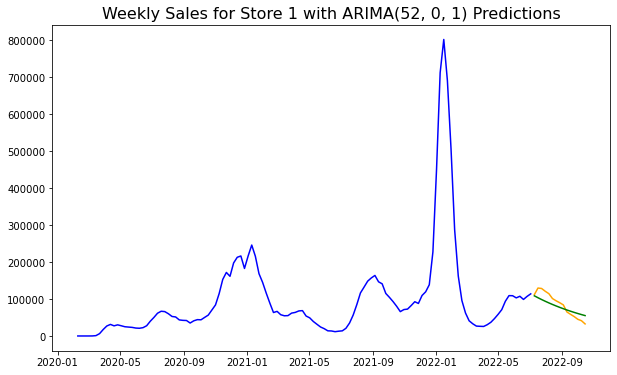

In [205]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

plt.title(label = 'Weekly Sales for Store 1 with ARIMA(52, 0, 1) Predictions', fontsize=16)
plt.show();

In [206]:
y_train.shape

(126,)

In [207]:
y_test.shape

(15,)

In [208]:

# Create train-test split.
y_train, y_test = train_test_split(df_cases_diff['new_case'], test_size = 0.1,shuffle = False)

In [209]:
mse = 99 * (10 ** 16)
mse

990000000000000000

In [210]:
metrics.mean_squared_error(y_test, preds_sarima)


328044210.2485147

In [211]:
# Starting MSE and (P, D, Q).
#mse = 99 * (10 ** 16)
#final_p = 0
#final_d = 0
#final_q = 0
#final_P = 0
#final_D = 0
#final_Q = 0
#for p in range(2):
#    for q in range(2):
#        for d in range(2):
#            for P in range(3):
#                for Q in range(3):
#                    for D in range(3):
#                        try:
#                            sarima = SARIMAX(endog = y_train,
#                                            order = (p, d, q),              # (p, d, q)
#                                            seasonal_order = (P, D, Q, 22))  # (P, D, Q, S)
                            
#                           print(P, D, Q)
#                            # Fit SARIMA model.
#                            model = sarima.fit()
#                            preds_sarima = model.predict(start = y_test.index[0], end = y_test.index[-1])
#                            print(f'The MSE for ({p}, {d}, {q})x({P},{D},{Q},22) is: {metrics.mean_squared_error(y_test, preds_sarima)}')#

                                            # Save for final report.
#                            if mse > metrics.mean_squared_error(y_test, preds_sarima):
#                                mse = metrics.mean_squared_error(y_test, preds_sarima)
                                
#                                final_p = p
#                                final_d = d
#                                final_q = q
#                                final_P = P
#                                final_D = D
#                                final_Q = Q

                            
#                        except:
#                            print("Exceprtion hahppened")
#                            pass
#print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},22).')
#print(f'This model has an MSE of {mse}.')

In [212]:
# 27690096390.04778
# 31324938754.810467
# 328044210.2485147
# CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
# The MSE for (1, 1, 1)x(2,2,2,22) is: 31324938754.810467
# Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,22).
# This model has an MSE of 328044210.2485147.

### Cases by State
____

In [213]:
df_cases.head()

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0


In [214]:
df_cases.groupby(by='state').sum()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AS,1382283,8250,5776,34
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383


In [215]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [216]:
df_cases.head(60).sort_values(by='state')

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AK,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,AR,0,0,0,0
2020-01-22,AS,0,0,0,0
2020-01-22,AZ,0,0,0,0
2020-01-22,CA,0,0,0,0
2020-01-22,CO,0,0,0,0
2020-01-22,CT,0,0,0,0
2020-01-22,DC,0,0,0,0


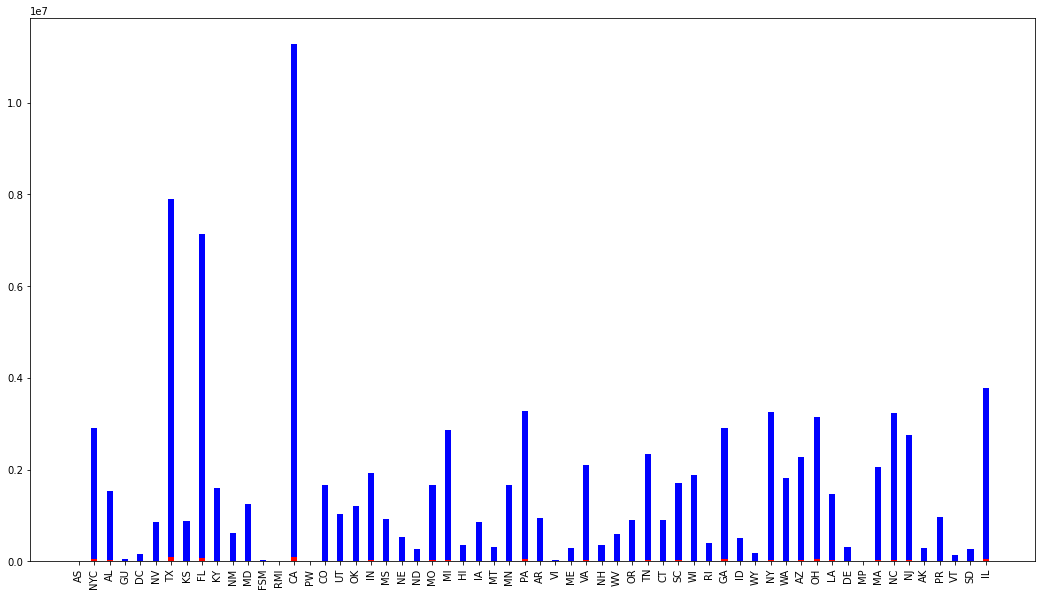

In [217]:
from turtle import color


df_cases.head()
# create data
plt.figure(figsize=(18,10))
x = df_cases['state']
y1 = df_cases['tot_cases']
y2 = df_cases['tot_death']
width = 0.40
  
# plot data in grouped manner of bar type
plt.bar(x, y1, width, color='b')
plt.bar(x, y2, width, color='r')
plt.xticks(rotation=90);


In [218]:
df_cases.groupby(by='state').sum().T

state,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
tot_cases,103800015,638327202,403775153,1382283,978893192,4364733842,658900625,367082955,64506024,123511033,...,985632802,3307212352,451582481,800947192,7188849,42676851,644705150,775370683,219275324,74375640
new_case,282632,1528319,954552,8250,2275235,11107087,1660829,888009,168122,310527,...,2327351,7691340,1040147,2099126,23103,133252,1825126,1875895,603256,177635
tot_death,533125,10915844,5830937,5776,15992140,50457009,6600246,7159317,929885,1674285,...,12689455,47538683,2350692,10365763,52258,288765,6442064,7409068,3159079,845670
new_death,1186,20498,12041,34,31644,95414,13348,11385,1383,3094,...,25437,89344,5018,21986,123,698,14417,15321,7387,1904


In [219]:
df_cases.groupby(by='state').sum()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AS,1382283,8250,5776,34
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383


In [220]:
df_cases.groupby(by='state').sum().shape

(60, 4)

In [221]:
df_fips = pd.read_csv('../data/states_fips.csv')
df_fips.head(50)

,name,postal_code,fips
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6
5,Colorado,CO,8
6,Connecticut,CT,9
7,Delaware,DE,10
8,District of Columbia,DC,11
9,Florida,FL,12


In [222]:
list_state = list(df_cases.groupby(by='state').sum().index)
list_state

['AK',
 'AL',
 'AR',
 'AS',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'FSM',
 'GA',
 'GU',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MP',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'NYC',
 'OH',
 'OK',
 'OR',
 'PA',
 'PR',
 'PW',
 'RI',
 'RMI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VI',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [223]:
list_fips = list(df_fips['postal_code'])
list_fips

['AL',
 'AK',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'DC',
 'FL',
 'GA',
 'HI',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY',
 'AS',
 'GU',
 'MP',
 'PR',
 'VI']

In [224]:
set(list_state) - set(list_fips)

{'FSM', 'NYC', 'PW', 'RMI'}

In [225]:
# These are not US state
# FSM: Federated States of Micronesia
# PW: Palau
# RMI: Republic of Marshall Islands
not_state_list = ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']

In [226]:
df_us = df_cases.groupby(by='state').sum()
df_us.shape

(60, 4)

In [227]:
df_us.loc['FSM']

tot_cases    753724
new_case      22005
tot_death      1997
new_death        51
Name: FSM, dtype: int64

In [228]:
# Deleting theses 'states' ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']
# Keeping DC and NYC. Total of 52 'US states'
df_us.drop(index=not_state_list,inplace=True)
df_us.shape

(52, 4)

In [229]:
df_us.sort_index()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383
DE,123511033,310527,1674285,3094


In [230]:
##!pip install plotly-geo==1.0.0
##!pip install geopandas==0.3.0
##!pip install pyshp==1.2.10
##!pip install shapely==1.6.3

In [6]:
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd

In [18]:
import plotly.graph_objects as go

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
fig = go.Figure(
    data = go.Choropleth(
    locations = df['code'], # Spatial coordinates
    z = df['total exports'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = ' US Covid Cases by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

## EDA - COVID Deaths in US
____

In [ ]:
df_deaths.info()

In [ ]:
df_deaths = df_deaths.groupby(by=df_deaths.index).sum()
df_deaths.head()

In [ ]:
df_deaths.drop(columns=['tot_cases','tot_death','new_case'], inplace=True)


In [ ]:
df_deaths.sort_values(by='new_death', ascending=True)

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(df_deaths['new_death']);

# Vacination data
____


In [ ]:
df_vacc=pd.read_csv('../data/covid_vaccination_trends.csv', low_memory=False)
df_vacc.info()

In [ ]:
df_vacc['Date'] = pd.to_datetime(df_vacc['Date'])
df_vacc.set_index('Date', inplace=True)
df_vacc.sort_index(inplace=True)


In [ ]:
df_vacc.columns

In [ ]:
df_vacc.drop(columns=['date_type','MMWR_week'],inplace=True)
df_vacc

In [ ]:
df_vacc.drop(columns=['Administered_Daily', 'Administered_Cumulative',
       'Administered_7_Day_Rolling_Average', 'Admin_Dose_1_Daily', 'Admin_Dose_1_Day_Rolling_Average',
       'Administered_Dose1_Pop_Pct', 'Administered_daily_change_report',
       'Administered_daily_change_report_7dayroll', 'Series_Complete_Daily',
       'Series_Complete_Cumulative', 'Series_Complete_Day_Rolling_Average',
       'Series_Complete_Pop_Pct', 'Booster_Daily', 'Booster_Cumulative',
       'Booster_7_Day_Rolling_Average', 'Additional_Doses_Vax_Pct',
       'Second_Booster_50Plus_Daily', 'Second_Booster_50Plus_Cumulative',
       'Second_Booster_50Plus_7_Day_Rolling_Average',
       'Second_Booster_50Plus_Vax_Pct'],inplace=True)


In [ ]:
df_vacc.info()

In [ ]:
df_vacc['Admin_Dose_1_Cumulative'] = df_vacc['Admin_Dose_1_Cumulative'].map( lambda x: x.replace(',','')).astype(int)
df_vacc.info()

In [ ]:
df_vacc = df_vacc.groupby(by=df_vacc.index).sum()
df_vacc.head()

In [ ]:
df_vacc.head(70)